# Example to use the sherpa plugin with the JeSeT interface

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
print(test_SEDs[2])
data=Data.from_file(test_SEDs[2])


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



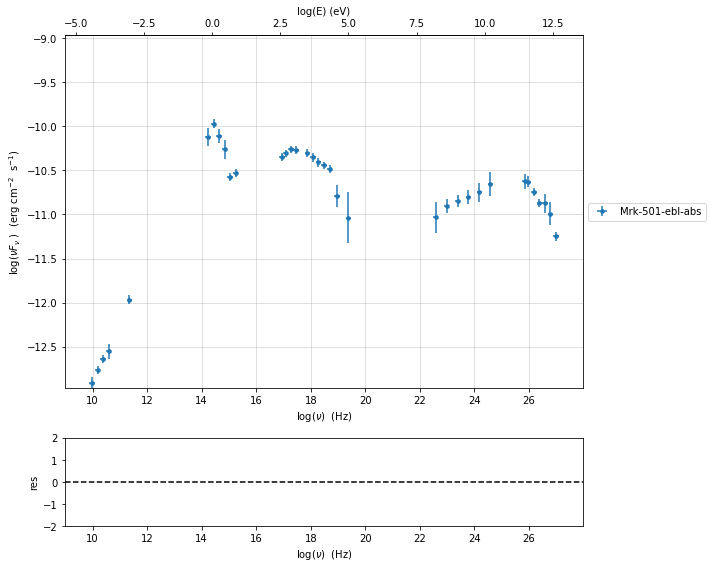

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_501.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



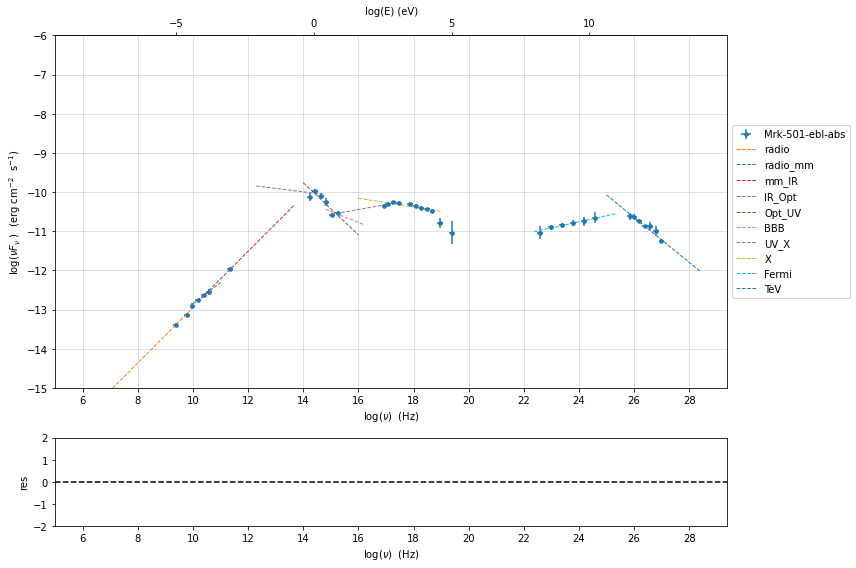

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411144e-02,-6.411144e-02,7.838965e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751721e-03,-1.751721e-03,1.127030e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437354e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884114e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006557e+01,-1.006557e+01,5.462528e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730764e-02,1.730764e-02,3.694887e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437354e-02)  nuFnu_p=-1.030068e+01 (err=+1.884114e-02) curv.=-6.411144e-02 (err=+7.838965e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.565399e-01,-1.565399e-01,2.551779e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.351917e-02,-4.351917e-02,2.032066e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.529709e+01,2.529709e+01,1.817241e-01,--,2.536916e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.058825e+01,-1.058825e+01,5.046950e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.529709e+01 (err=+1.817241e-01)  nuFnu_p=-1.058825e+01 (err=+5.046950e-02) curv.=-1.565399e-01 (err=+2.551779e-02)



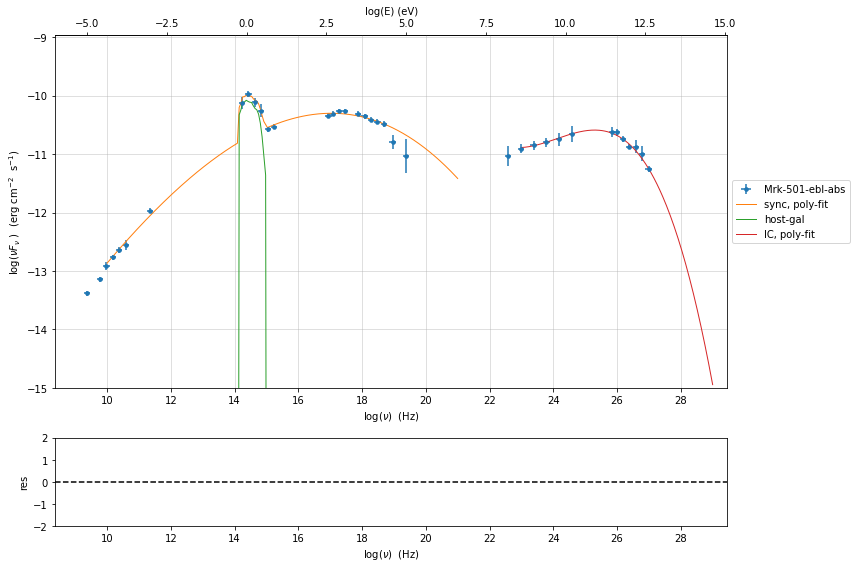

In [8]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.056955e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.703917e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.087137e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


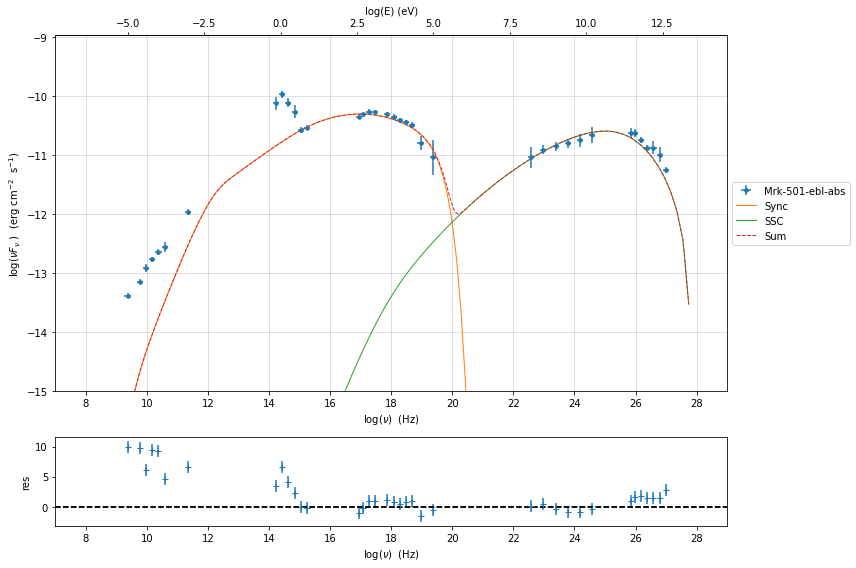

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_model_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting with Sherpa


In [11]:
from jetset.template_2Dmodel import EBLAbsorptionTemplate
ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')

In [12]:
from jetset.jet_model import Jet
prefit_jet=Jet.load_model('prefit_jet.pkl')


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.703917e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.087137e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.056955e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


==> par: z_cosm from model: Franceschini_2008 linked to same parameter in model jet_leptonic


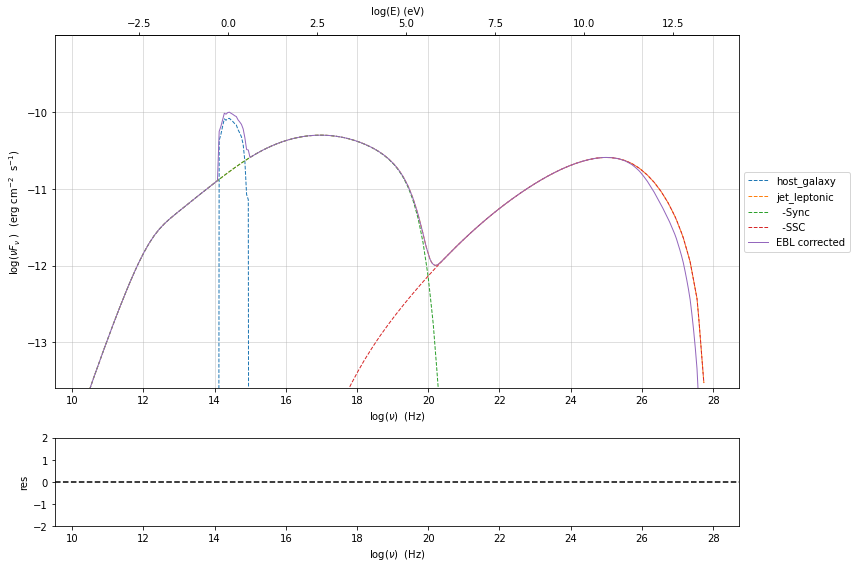

In [13]:
composite_model=FitModel(nu_size=500,name='EBL corrected',template=my_shape.host_gal)
composite_model.add_component(prefit_jet)
composite_model.add_component(ebl_franceschini)
composite_model.link_par(par_name='z_cosm', from_model='Franceschini_2008', to_model='jet_leptonic')
composite_model.composite_expr='(jet_leptonic+host_galaxy)*Franceschini_2008'
composite_model.eval()
composite_model.plot_model()

In [14]:
composite_model.freeze('jet_leptonic','z_cosm')
composite_model.freeze('jet_leptonic','R_H')
composite_model.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
composite_model.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
composite_model.jet_leptonic.parameters.gmax.fit_range=[1E5,1E7]
composite_model.host_galaxy.parameters.nuFnu_p_host.frozen=False
composite_model.host_galaxy.parameters.nu_scale.frozen=True

In [15]:
from jetset.minimizer import ModelMinimizer
composite_model.jet_leptonic.parameters.z_cosm.frozen=True

model_minimizer_lsb=ModelMinimizer('sherpa')
best_fit=model_minimizer_lsb.fit(composite_model,sed_data,1E11,1E29,fitname='SSC-best-fit-sherpa',repeat=1)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 


0it [00:00, ?it/s]

jetset model name R renamed to  R_sh due to sherpa internal naming convention
- best chisq=8.12488e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-sherpa


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (cm2 s),-1.006191e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.730764e-02,-2.000000e+00,2.000000e+00,False,True
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,2.022419e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.138670e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.706973e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.050203e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.152067e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.130435e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.490317e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True



converged=True
calls=302
mesg=


Parameter,Best-fit value,Approximate error
EBL corrected.nuFnu_p_host,-10.0619,± 0.0512703
EBL corrected.gmin,202.242,± 243.682
EBL corrected.gmax,2.13867e+06,± 0
EBL corrected.N,9.70697,± 11.5058
EBL corrected.gamma0_log_parab,4050.2,± 0
EBL corrected.s,2.15207,± 0.0792132
EBL corrected.r,0.213043,± 0.0251923
EBL corrected.R_sh,1.49032e+16,± 0
EBL corrected.B,0.011427,± 0.00206829
EBL corrected.beam_obj,43.7988,± 4.74205


dof=21
chisq=8.124876, chisq/red=0.386899 null hypothesis sig=0.994592

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
host_galaxy,nuFnu_p_host,-1.006191e+01,-1.006191e+01,5.127031e-02,--,-1.006557e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730764e-02,--,--,--,1.730764e-02,-5.000000e-01,5.000000e-01,True
jet_leptonic,gmin,2.022419e+02,2.022419e+02,2.436816e+02,--,4.703917e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.138670e+06,2.138670e+06,0.000000e+00,--,2.310708e+06,1.000000e+05,1.000000e+07,False
jet_leptonic,N,9.706973e+00,9.706973e+00,1.150583e+01,--,7.087137e+00,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.050203e+03,4.050203e+03,0.000000e+00,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.152067e+00,2.152067e+00,7.921319e-02,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.130435e-01,2.130435e-01,2.519229e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.490317e+16,1.490317e+16,0.000000e+00,--,1.056955e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True


-------------------------------------------------------------------------




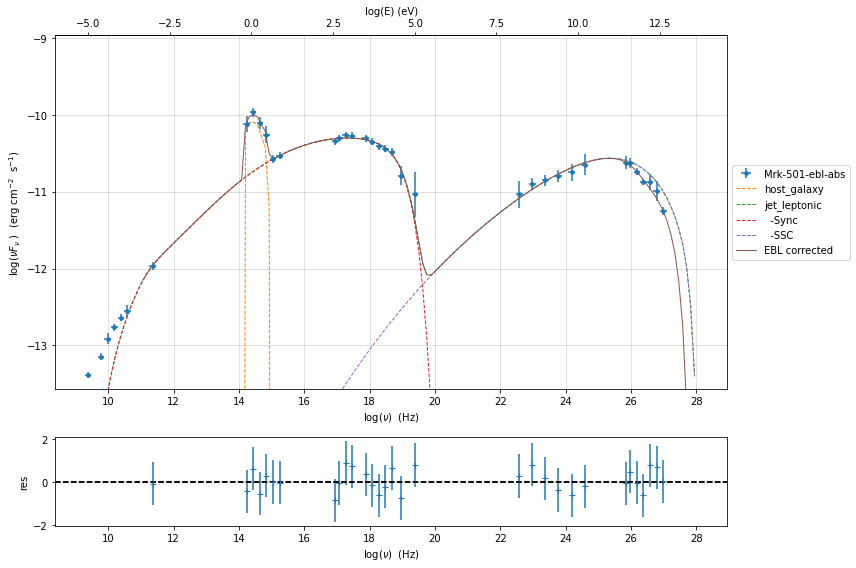

In [16]:
composite_model.set_nu_grid(1E6,1E30,200)
composite_model.eval()
p=composite_model.plot_model(sed_data=sed_data)

Using the ``sherpa_fitter`` you can access all the sherpa fetarues https://sherpa.readthedocs.io/en/latest/fit/index.html

In [17]:
model_minimizer_lsb.minimizer.sherpa_fitter.est_errors()


Parameter,Best-fit value,Lower Bound,Upper Bound
EBL corrected.nuFnu_p_host,-10.0619,-0.0510228,0.0510228
EBL corrected.gmin,202.242,-32.9117,32.9117
EBL corrected.gmax,2.13867e+06,-41386.5,41386.5
EBL corrected.N,9.70697,-2.56835,2.56835
EBL corrected.gamma0_log_parab,4050.2,-620.3,620.3
EBL corrected.s,2.15207,-0.0219673,0.0219673
EBL corrected.r,0.213043,-0.019551,0.019551
EBL corrected.R_sh,1.49032e+16,-2.2507e+15,2.2507e+15
EBL corrected.B,0.011427,-0.00106949,0.00106949
EBL corrected.beam_obj,43.7988,-3.7201,3.7201


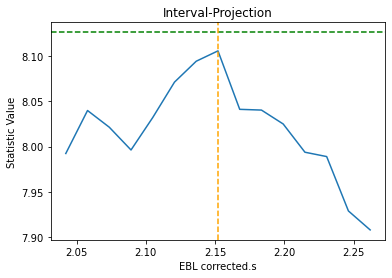

In [18]:
from sherpa.plot import IntervalProjection
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=15)
iproj.calc(model_minimizer_lsb.minimizer.sherpa_fitter, model_minimizer_lsb.minimizer._sherpa_model.s)
iproj.plot()